In [1]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap(name='jet')

import seaborn as sns
sns.set_style("darkgrid")

import tensorflow as tf
import keras
from keras import models
from keras.preprocessing.image import ImageDataGenerator, img_to_array

from sklearn.metrics import classification_report

from vis.visualization import visualize_saliency, overlay
from vis.utils import utils

import warnings #done with notebook, just supressing warnings for aesthetics
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Detecting Breast Cancer with Computer Vision

The goal for this project is to create a tool that doctors could use to help diagnose breast cancer. My approach for this project is to try a few different convolutional neural network architectures. We will see which model performs best, and use that model to create saliency heat maps. These heatmaps will help us understand how the model is making decisions. The heat maps could also help a doctor verify that our model is infact detecting cancer, and not making strong decisions by using something in the mammograms unrelated to cancer.

In [2]:
#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with sci kits classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, labels in gen:
        #get true labels for batch and store them
        y_true.extend(np.argmax(labels, axis=1))
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
    print(classification_report(y_true, y_pred))
    
    
#Loops through a list of image generators, plots class balance, and prints stats
def plot_gen(gen_list, title='Class Balance'):
    
    #Get True labels for plot from generator list
    y_true = []
    for gen in gen_list:
        gen.reset()
        for _ , labels in gen:
            y_true.extend(np.argmax(labels, axis=1))
            if gen.batch_index == 0:
                break
    
    #Plot class balance            
    plt.figure(figsize=(10, 5))
    plt.title(title)
    sns.countplot(y_true)
    plt.show()
    
    #Print stats
    pos_cnt = sum(y_true)
    neg_cnt = (len(y_true) - pos_cnt)
    print('Positive Class Count:{}'.format(pos_cnt))
    print('Positive Class:{}%'.format(round(pos_cnt / len(y_true) * 100)))
    print('Negative Class Count:{}'.format(neg_cnt))
    print('Negative Class:{}%'.format(round(neg_cnt / len(y_true) * 100)))
    
    
## Takes a list of image files and plots the image, heatmap, and an overlay.
## Makes a prediction on the image and adds the prediction to the title
def plot_heat_map(paths, img_width=299, img_height=299):
    for x in paths:
        
        #load image to plot
        img = utils.load_img(x, target_size=(img_width, img_height))
        
        #convert to 3 channel for model
        stacked_img = np.stack((img,)*3, -1)
        
        #get saliency gradients
        grads = visualize_saliency(model,
                        layer_idx=-1, 
                        filter_indices=0,
                        backprop_modifier='guided',
                        seed_input=stacked_img, 
                        )
        #apply colormap to saliency gradients and remove alpha channel
        #this is the heatmap to plot
        heatmap = cmap(grads)[:,:,:3]
        
        #get prediction for image
        p_img = np.expand_dims(stacked_img, axis=0)
        p_img = p_img / 255
        prediction = model.predict(p_img)
        prediction = np.argmax(prediction, axis=1)
        
        #create an overlay with image and heatmap to plot
        overlay_img = overlay(np.uint8(heatmap * 255), stacked_img, alpha=0.5)
        
        #plot images with prediction for title
        fig = plt.figure(figsize=(17, 8))
        ax1 = fig.add_subplot(1,3,1)
        plt.title('pos image / prediction = ' + str(prediction))
        ax1.imshow(img, 'gray')
        ax2 = fig.add_subplot(1,3,2)
        ax2.imshow(heatmap)
        ax3 = fig.add_subplot(1,3,3)
        ax3.imshow(overlay_img)

## Train, Validate, and Test

It's important to create a train, test , and validation data sets. By creating a validation and test sets, we can be sure that our data will generalize to a real world use case. Often times we will use the test set during the training process to make sure our model is generalizing well. However, this process of tuning our model to generalize well introduces bias to the test set. By going the extra step and creating a validation set, we can use this set to make sure our model is generalizing well with out introducing bias to our test set in the training process.

In this project we had 55,885 images. We decided on a 70-15-15 split for our train test and validation data sets. This gave us about 1,000 positive images in test and validation sets, and 5,000 positive images for training. 

In [3]:
#This cell creates 4 image data generators for train, test, and validation.
#The Fourth generator is a copy of train with no image augmentation applied.

train_dir = 'C:\\users\\will\\ds\\mammo\\train'
valid_dir = 'C:\\users\\will\\ds\\mammo\\validation'
test_dir = 'C:\\users\\will\\ds\\mammo\\test'

img_width, img_height = 299, 299
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb') #RGB is used here because inception architecture is RGB / 3 channel

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

train_no_aug_gen = test_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 39011 images belonging to 2 classes.
Found 8436 images belonging to 2 classes.
Found 8438 images belonging to 2 classes.
Found 39011 images belonging to 2 classes.


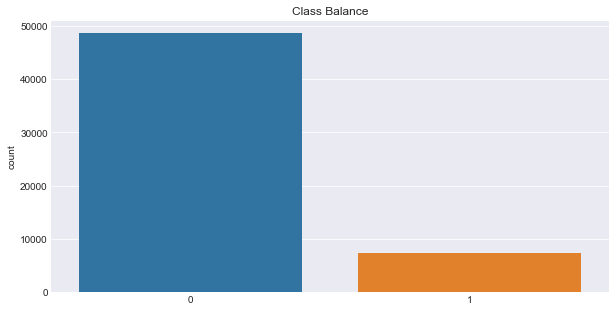

Positive Class Count:7289
Positive Class:13.0%
Negative Class Count:48596
Negative Class:87.0%


In [4]:
gens = [test_generator, validation_generator, train_no_aug_gen]
plot_gen(gens)

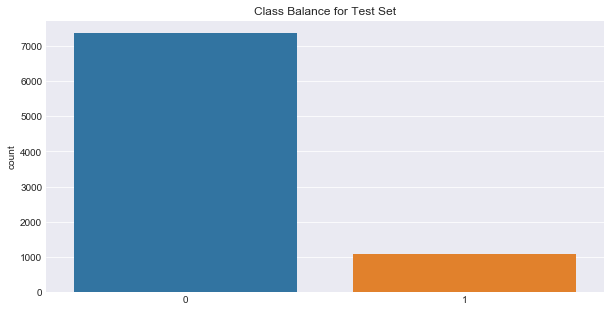

Positive Class Count:1094
Positive Class:13.0%
Negative Class Count:7344
Negative Class:87.0%


In [5]:
gen = [test_generator]
plot_gen(gen, title='Class Balance for Test Set')

## Class Balance

Here you can see the class balance of our data set. This is an important aspect of machine learning. Machine learning models require balanced data sets to achieve accurate results. If the dataset is not balanced the model will favor the majority class. 

There are number of approaches to solve class imbalance. Undersampling is where you undersample the majority class to achieve balance. This technique is only useful if you have a lot of data. Neural networks are very data hungry. Our data set is fairly large, but undersampling would remove too much of our data because the data is very imbalanced. Oversampling is one where you oversample the minority class to achieve balance. The downside of over sampling is that often your model will overfit on the training data very quickly because the samples are duplicated. This could work, but we're going to do something a bit stronger.  
To solve this problem we are going to use class weights. Class weighting is a technique where you weight the under represented class more heavily. The model will adjust the parameters according to the samples class weight. The class weights we used were inverse floats of the class percentage. This helped us produce accurate results.

To properly measure a model that uses a dataset with imbalanced classes we have to use different metrics. Accuracy is not a good metric for imbalanced classes simply because you can get high accuracy just by guessing the majority class everytime. Precision, Recall, and F1-score are very strong metrics for imbalanced classes. 

## Inception V3 results

This was the strongest model of the three we tried. It scored the highest across all metrics. It's also the model we use to create the saliency heatmaps below. If you would like to learn more about the training process of this model and the other models we tried refer to their training notebooks.

In [6]:
#Load inception model with our train weights, verify it works with metric report on test data set
model = models.load_model('models2\\IV3.h5')
model.load_weights('mammo-weights-IV3\weights-improvement-33-0.98.hdf5')
predict_and_report(test_generator, model)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99      7344
          1       0.95      0.94      0.94      1094

avg / total       0.99      0.99      0.99      8438



## Saliency Heatmaps

These are the heatmaps our saliency gradients made. At first glance I thought some of them had fairly poor results, but after looking at some of the negative images in our data set. I realized that these white blotches in the images aren't always cancer, often times they are benign calcifications. We would need a doctor to verify our results, but it looks like our model is making fairly good decisions based on the heatmaps, despite some light noise.

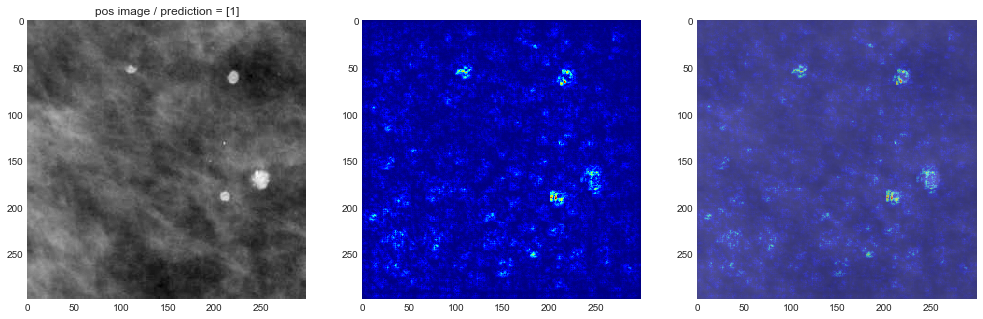

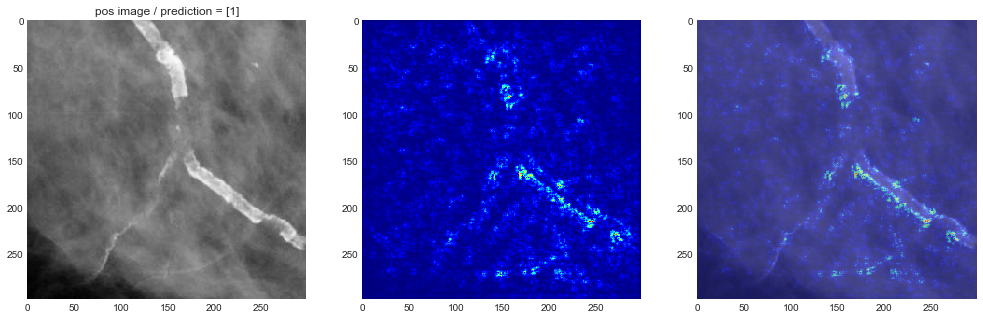

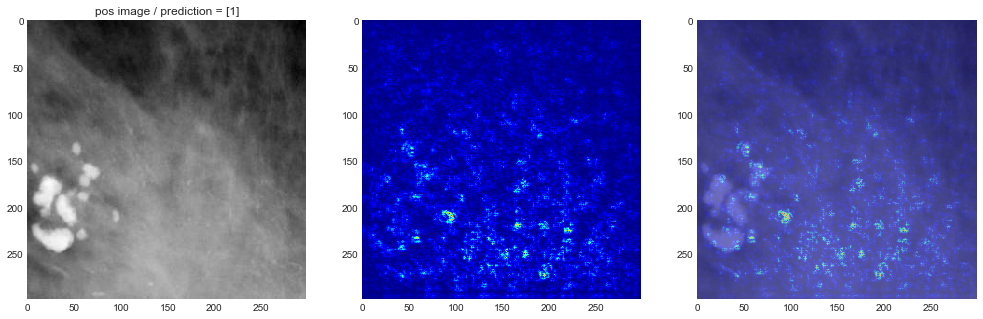

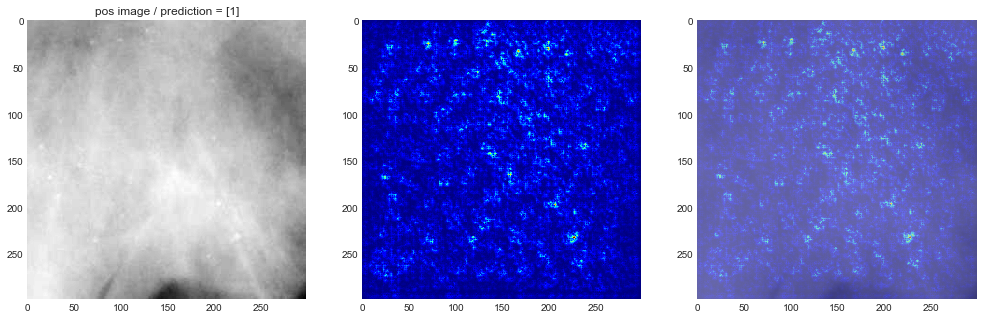

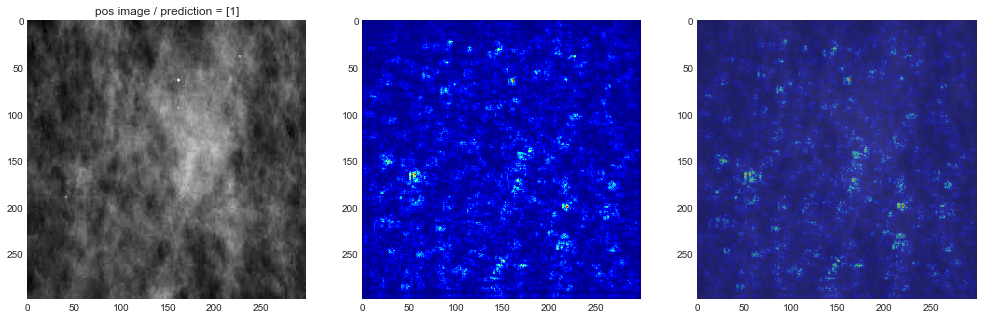

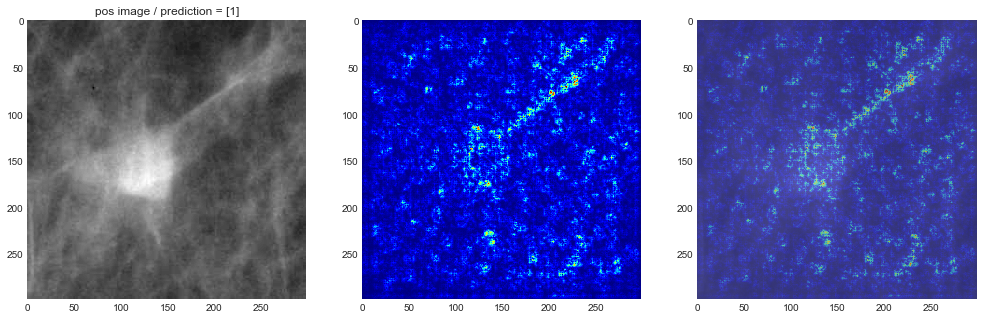

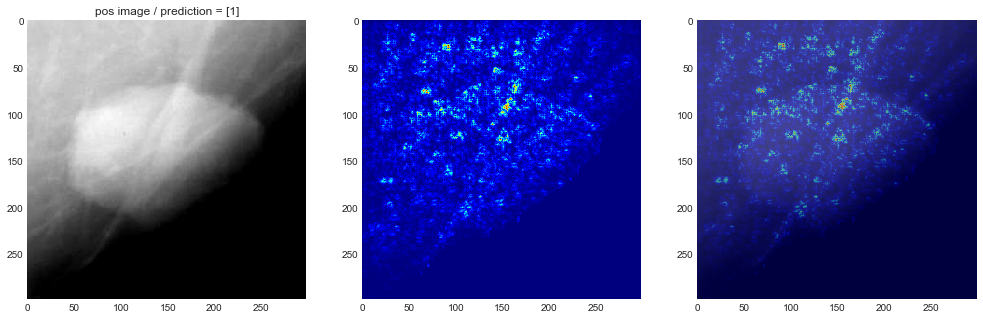

In [7]:
#Remove grid for image plots
sns.set_style("darkgrid", {'axes.grid' : False})

paths = [r'C:\Users\Will\ds\mammo\train\pos\positive2640.jpg',
        r'C:\Users\Will\ds\mammo\test\pos\positive920.jpg',
        r'C:\Users\Will\ds\mammo\test\pos\positive967.jpg',
        r'C:\Users\Will\ds\mammo\test\pos\positive2.jpg',
        r'C:\Users\Will\ds\mammo\test\pos\positive884.jpg',
        r'C:\Users\Will\ds\mammo\test\pos\positive993.jpg',
        r'C:\Users\Will\ds\mammo\test\pos\positive362.jpg']

plot_heat_map(paths)